<h1>Содержание<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Исследовательский-анализ-данных" data-toc-modified-id="Исследовательский-анализ-данных-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Исследовательский анализ данных</a></span></li><li><span><a href="#Обучение-модели" data-toc-modified-id="Обучение-модели-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Обучение модели</a></span></li><li><span><a href="#Анализ-обученной-модели" data-toc-modified-id="Анализ-обученной-модели-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Анализ обученной модели</a></span></li><li><span><a href="#Чек-лист" data-toc-modified-id="Чек-лист-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Чек-лист</a></span></li></ul></div>

# Определение возраста покупателей


Сетевой супермаркет N внедряет систему компьютерного зрения для обработки фотографий покупателей.  
Фотофиксация в прикассовой зоне поможет определять возраст клиентов, чтобы:
* анализировать покупки и предлагать товары, которые могут заинтересовать покупателей этой возрастной группы;
* аонтролировать добросовестность кассиров при продаже алкоголя.

**Задачи**
* обучение модели, для определения приблизительного возраста человека по фотографии;
* построение модели со значением метрики качества $MAE <= 8$

В нашем распоряжении набор фотографий людей с указанием возраста.


## Исследовательский анализ данных


In [1]:
# импортируем необходимые для работы библиотеки
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator


In [2]:
# выполним загрузку данных
labels = pd.read_csv('/datasets/faces/labels.csv')
train_datagen = ImageDataGenerator(rescale=1./255)
train_gen_flow = train_datagen.flow_from_dataframe(dataframe=labels,
                                                   directory='/datasets/faces//final_files',
                                                   x_col='file_name',
                                                   y_col='real_age',
                                                   target_size=(224, 224),
                                                   batch_size=32,
                                                   class_mode='raw',
                                                   seed=12)


Found 7591 validated image filenames.


In [3]:
# выведем информацию о располагаемых данных
print(f'\nОбъектов: {labels.shape[0]}')
print(f'Признаков: {labels.shape[1]}')
print(f'Пропусков: {labels.isna().sum().sum()}')
print(f'Уникальных значений: {len(labels.real_age.unique())}')
print('\n\nПервые объекты и признаки:')
display(labels.head())
print('\n\nОбщая информация о наборе данных:\n')
labels.info()
print('\n\nРазброс значений количественных признаков:')
display(labels.describe().T)
print()



Объектов: 7591
Признаков: 2
Пропусков: 0
Уникальных значений: 97


Первые объекты и признаки:


,file_name,real_age
0,000000.jpg,4
1,000001.jpg,18
2,000002.jpg,80
3,000003.jpg,50
4,000004.jpg,17




Общая информация о наборе данных:

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7591 entries, 0 to 7590
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   file_name  7591 non-null   object
 1   real_age   7591 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 118.7+ KB


Разброс значений количественных признаков:


,count,mean,std,min,25%,50%,75%,max
real_age,7591.0,31.201159,17.14506,1.0,20.0,29.0,41.0,100.0


In [4]:
# функция для построения гистограммы
def plotting_hist(data, n_bins, title='', x_label='', y_label =''):
    fig = plt.figure(figsize=(20, 7))
    ax = fig.add_subplot()
    ax.hist(data, bins=n_bins, color='#8eb897', alpha=0.7)
    
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.grid(axis='y', alpha=0.3)
    ax.set_title(f'\n{title}\n', size=16)
    ax.set_xlabel(x_label, size=13)
    ax.set_ylabel(y_label, size=13)
    
    ax.axvline(data.median(),
               linestyle = ':',
               color = 'red',
               label = 'Медиана')
    ax.axvline(data.mean(),
               linestyle = ':',
               color = 'orange',
               label = 'Среднее')
    ax.axvline(data.quantile(0.1),
               linestyle = ':',
               color = 'black',
               label = '1% значений')
    ax.axvline(data.quantile(0.99),
               linestyle = ':',
               color = 'black',
               label = '99% значений')
    ax.legend(loc='best', fontsize='medium', shadow=True,)

    plt.show()
    

In [5]:
# функция для построения диаграммы размаха
def plotting_boxplot(data, title='', x_label=''):
    fig = plt.figure(figsize=(12, 3))
    ax = fig.add_subplot()
    ax.boxplot(data, vert=False)
    
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    plt.title(f'\n{title}\n', size=14)
    plt.grid(axis='x', alpha=0.3)
    ax.set_xlabel(x_label, size=10)
    
    plt.show()
    

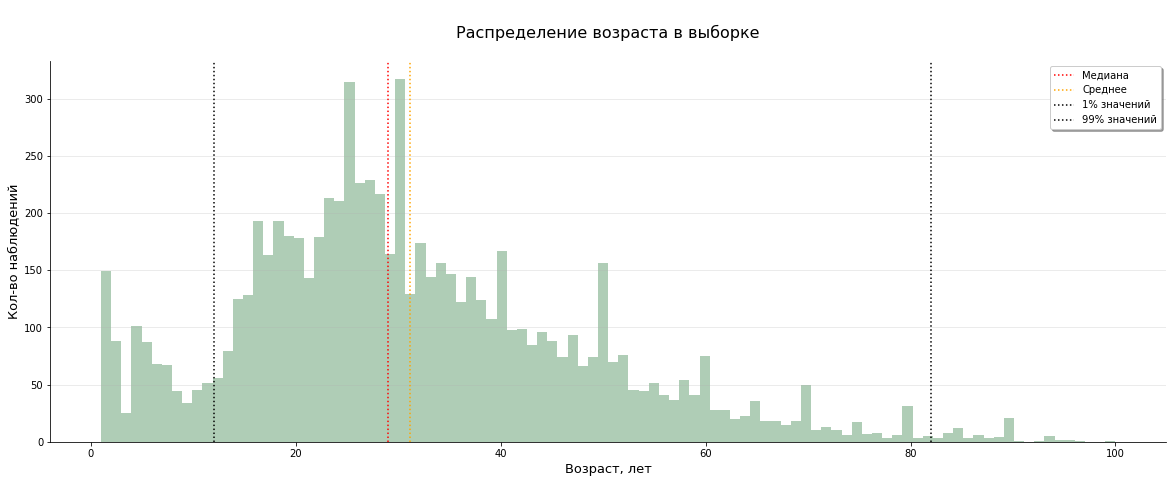

In [6]:
# построим гистограмму распределения возраста в выборке
plotting_hist(labels['real_age'],
              n_bins=100,
              title='Распределение возраста в выборке',
              x_label='Возраст, лет',
              y_label='Кол-во наблюдений')


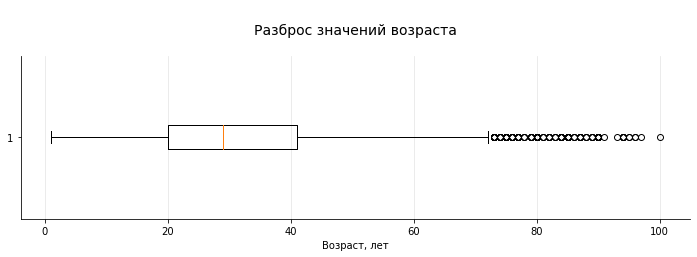

In [7]:
# посмотрим на диаграмму размаха
plotting_boxplot(labels['real_age'], 'Разброс значений возраста', 'Возраст, лет')


In [8]:
# получим объект с парами "изображения — метки" для печати изображений
features, target = next(train_gen_flow)
features.shape


(32, 224, 224, 3)

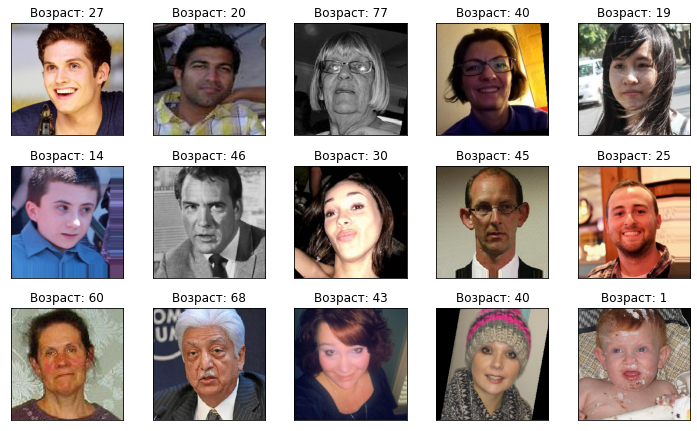

In [9]:
# выведем на экран 15 фотографий
fig = plt.figure(figsize=(10, 10))
for i in range(15):
    fig.add_subplot(5, 5, i+1)
    plt.imshow(features[i])
    plt.title(f'Возраст: {target[i]}')
    plt.xticks([])
    plt.yticks([])
    plt.tight_layout()
    

**Выводы**

Данные загружены и изучены:

* в представленной выборке 7 591 наблюдение, которому соответствует 7 591 изображение, размещенное в одной папке;
* выборка содержит 97 значений возраста - от 1 года до 100 лет, со средним и медианным возрастами 31 год и 29 лет соответственно;
* распределение ассиметрично, скошено вправо, есть выбросы, которые тем не менее являются нормой и должны быть сохранены;
* исходя из выведенных на экран изображений - в папке собраны фотографии людей, многие из которых с деформацией (искажения, отсутствие или искажение цвета), шумами, различным освещением, что, вероятно, скажется на качестве будущей модели;
* также на качество модели может повлиять наличие в выборке большого количества людей в возрасте 1-2 года, которые по факту еще не являются покупателями, но котрых тоже должна уметь идентифицировать модель.


## Обучение модели

```python
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.resnet import ResNet50
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Flatten, Dense, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam
import numpy as np
import pandas as pd

# функция загрузки обучающей выборки
def load_train(path):
    
    labels = pd.read_csv(path + 'labels.csv')
    train_datagen = ImageDataGenerator(rescale=1./255, validation_split=0.25)
    train_gen_flow = train_datagen.flow_from_dataframe(dataframe=labels,
                                                       directory=path + 'final_files',
                                                       x_col='file_name',
                                                       y_col='real_age',
                                                       target_size=(224, 224),
                                                       batch_size=32,
                                                       class_mode='raw',
                                                       subset='training',
                                                       seed=12)

    return train_gen_flow

# функция загрузки тестовой выборки
def load_test(path):
    
    labels = pd.read_csv(path + 'labels.csv')
    test_datagen = ImageDataGenerator(rescale=1./255, validation_split=0.25)
    test_gen_flow = test_datagen.flow_from_dataframe(dataframe=labels,
                                                     directory=path + 'final_files',
                                                     x_col='file_name',
                                                     y_col='real_age',
                                                     target_size=(224, 224),
                                                     batch_size=32,
                                                     class_mode='raw',
                                                     subset='validation',
                                                     seed=12)

    return test_gen_flow

# функция создания модели
def create_model(input_shape):
    
    backbone = ResNet50(input_shape=input_shape,
                        weights='imagenet', 
                        include_top=False)
    
    model = Sequential()
    model.add(backbone)
    model.add(GlobalAveragePooling2D())
    model.add(Dense(units=1, activation='relu'))
    
    optimizer = Adam(lr=0.0001)
    model.compile(optimizer=optimizer, loss='mse', metrics=['mae'])

    return model

# функция обучения модели
def train_model(model, train_data, test_data, batch_size=None, epochs=5,
               steps_per_epoch=None, validation_steps=None):
    
    if steps_per_epoch is None:
        steps_per_epoch = len(train_data)
    if validation_steps is None:   
        validation_steps=len(test_data)

    model.fit(train_data,
              validation_data=test_data,
              batch_size=batch_size,
              epochs=epochs,
              steps_per_epoch=steps_per_epoch,
              validation_steps=validation_steps,
              verbose=2)

    return model

```

```
Train for 178 steps, validate for 60 steps

Epoch 1/5
178/178 - 50s - loss: 249.1394 - mae: 11.3782 - val_loss: 721.0068 - val_mae: 21.9710

Epoch 2/5
178/178 - 41s - loss: 64.2006 - mae: 6.0905 - val_loss: 616.0179 - val_mae: 19.7976

Epoch 3/5
178/178 - 50s - loss: 31.6146 - mae: 4.3160 - val_loss: 238.5606 - val_mae: 11.8099

Epoch 4/5
178/178 - 51s - loss: 20.5075 - mae: 3.4815 - val_loss: 123.5098 - val_mae: 8.5587

Epoch 5/5
178/178 - 42s - loss: 15.4567 - mae: 3.0187 - val_loss: 82.7018 - val_mae: 6.9264

Test MAE: 6.9264


```

## Анализ обученной модели

* Задачи исследования выполнены:
  * обучена модель, для определения приблизительного возраста человека по фотографии;
  * Построена модель со значением метрики качества 𝑀𝐴𝐸 <= 8;
  * МАЕ модели на тестовой выборке - 6.9264


* Для обучения модели был использован датасет с 7591 преимущественно цветным изображением размерами 224 на 224 пикселя;
* При загрузке датасета аргументация не использовалась;
* Обучающая и тестовые выборки были разделены в соотношении 75:25;
* Для обучения была использована предобученная на ImageNet модель архитектуры ResNet50, которая позволила уменьшить проблемы с недообучением и оптимизацией модели.
* Дополнительно к ResNet50 в модель был добавлен выходной полносвязный слой с одним нейроном и функцией активации 'ReLU'.
* В качестве функции потерь для ускорения обучения использована метрика Mean Squared Error, метрикой качества в соответствии с поставленной задачей выступила Mean Absolute Error.
